In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cvxpy as cp
from scipy.integrate import odeint
from utils import *
import time


# MPC Controller

In [2]:
dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum()

In [3]:
d2r = np.pi/180
r2d = 180/np.pi

In [29]:
#now make the time series
max_time = 30
freq = 10       # frequency/Hz
dt = 1.0 / freq # useful for the animation function
t = np.linspace(0, max_time, int(freq*max_time+1))


# s_0 = ([x, y, θ(drone angle), ϕ(pendulum angle), dx, dy, dθ, dϕ]) 
s_0 = np.array([0, 0, 2*np.pi, np.pi-30*d2r, 0, 0, 0, 0])  # Initial state.
# s_0 = np.array([0, 0, 2*np.pi, 0.1, 0, 0, 0, 0])
s_star = np.array([5, 8, 2*np.pi, np.pi, 0, 0, 0, 0])       # Final state.
u_star = np.ones(dynamics.control_dim) * (dynamics.mp+dynamics.mQ) * dynamics.g/2 # Final control.

In [149]:
def MPC(A,B,Q,R, state, dynamics, s_star, u_star, horizon = 30):
    state_dim = dynamics.state_dim
    control_dim = dynamics.control_dim
    s = cp.Variable((horizon+1,state_dim))
    u = cp.Variable((horizon,control_dim))
    T_max = 100
    constraints = [u >= 0]
    constraints += [s[0] == state]
    obj = cp.quad_form((s[horizon]-s_star),5*Q)
    for i in range(horizon):
        constraints += [s[i+1] == s[i] + A @ (s[i] - s_star) + B @ (u[i] - u_star)]
        constraints += [cp.norm(u[i],"inf") <= T_max]
        obj += cp.quad_form((s[i] - s_star),Q) + cp.quad_form(u[i] - u_star,R) 

    prob = cp.Problem(cp.Minimize(obj),constraints)
    prob.solve()
    U = u.value
    return U[0]

In [150]:
s2_init_list = [s_0]
noise = False
circle_trj = True
#integrate dynamics output
s2_t_list = []
u_t_list = []
Q = 3 * np.identity(dynamics.state_dim) 
R = np.identity(dynamics.control_dim)
A = dt * dynamics.dfds(s_star, None, u_star)
B = dt * dynamics.dfdu(s_star, None, u_star)

for s2_0 in s2_init_list:
    s = np.zeros((t.shape[0], dynamics.state_dim))
    s[0] = s2_0
    u = np.zeros([t.shape[0], dynamics.control_dim])
#     u[0] = u_star
    for k in range(len(t)-1):
        if circle_trj:
            w = 2*np.pi/30
            x_des = 2*np.cos(w*t[k])
            y_des = 2*np.sin(w*t[k])
            dx_des = -2*w*np.sin(w*t[k])
            dy_des = 2*w*np.cos(w*t[k])
            s_star = np.array([x_des, y_des, 2*np.pi, np.pi, dx_des, dy_des, 0, 0])
            if k == 0:
                s[0] = s_star
        u[k] = MPC(A,B,Q,R,s[k],dynamics, s_star,u_star,horizon = 40)
        s[k+1] = odeint(dynamics, s[k], t[k: k+2], (u[k],))[1]
        if noise:
            mean = np.zeros(8)
            cov = np.diag(np.array([0,0,1e-3,1e-3,0,0,0,0]))
            s[k+1] += np.random.multivariate_normal(mean,cov,1)[0]
        
    s2_t_list.append(s)
    u_t_list.append(u)

/Users/albertchan/miniforge3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [30]:
def swing_up_control(ϕ,dϕ,g,L,mp,Ip):
    E = 0.5 * Ip * dϕ**2 + 0.5 * mp * g * L * (np.cos(np.pi-ϕ) - 1)
    k = 2
    u = k *(E - 0)* np.sign(-dϕ * np.cos(np.pi-ϕ))
    return u

In [151]:
s2_t = s2_t_list[0] 
u_t = u_t_list[0]
animate_planar_quad_with_inverted_pendulum(t, s2_t[:,0], s2_t[:,1], s2_t[:,2], s2_t[:,3], display_in_notebook=True)

(401,)

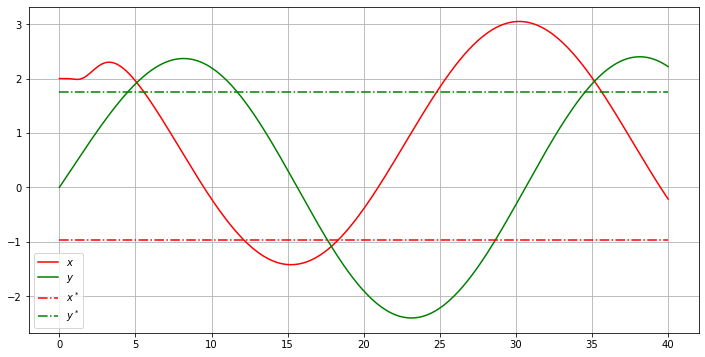

In [152]:
#Now plot the position vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,1],'g',label='$y$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[0]*np.ones_like(t),'-.r',label='$x^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[1]*np.ones_like(t),'-.g',label='$y^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

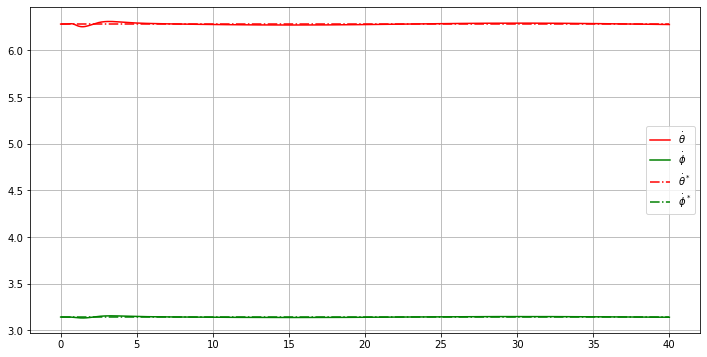

In [153]:
#Now plot the angle vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,2],'r',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,3],'g',label='$\\dot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[2]*np.ones_like(t),'-.r',label='$\\dot{\\theta}^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[3]*np.ones_like(t),'-.g',label='$\\dot{\\phi}^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

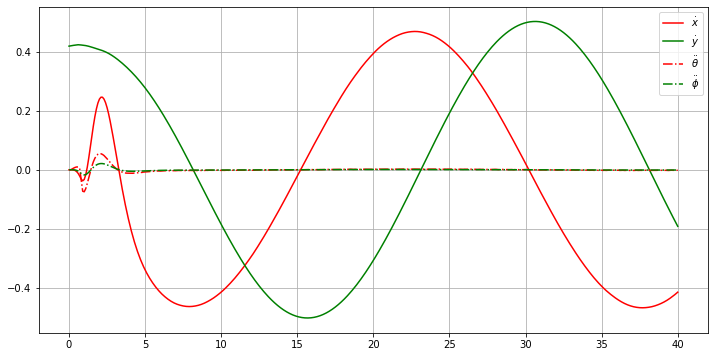

In [154]:
#Now plot the velocity vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,4],'r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,5],'g',label='$\\dot{y}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,6],'-.r',label='$\\ddot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,7],'-.g',label='$\\ddot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

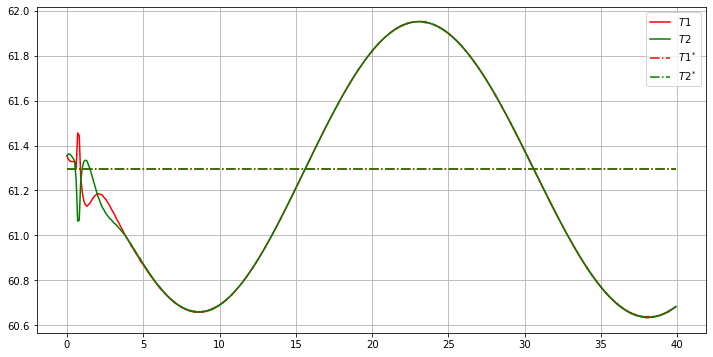

In [155]:
#Now plot the control vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t[:-1],u_t[:-1,0],'r',label='$T1$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u_t[:-1,1],'g',label='$T2$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.r',label='$T1^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.g',label='$T2^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here